<a href="https://colab.research.google.com/github/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Data_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center><b><u>Data Disovery Phase</u></b></center> </h3>
<h4><center><b>Prepared By: Simranjeet Randhawa</b></center> </h4>
<h4><center><b>Student ID: 200412297</b></center> </h4>




<h3><b> Data Discovery Phase </b></h3>

<h4><b>1. Data Gathering</b></h4>
<p align="justify">Data Gathering is the first step of the machine learning life cycle. The goal of this step is to identify and obtain all data-related problems.
In this step, we need to identify the different data sources, as data can be collected from various sources such as files, database, internet, or mobile devices. It is one of the most important steps of the life cycle. The quantity and quality of the collected data will determine the efficiency of the output. The more will be the data, the more accurate will be the prediction.
This step includes the below tasks:
<ul>
<li>Identify various data sources</li>
<li>Collect data</li>
<li>Integrate the data obtained from different sources</li>
</ul> By performing the above task, we get a coherent set of data, also called as a dataset. It will be used in further steps.</p>

<h4><b>2. Identifying Data Sources</b></h4>
<p align="justify">
<ul>

<li><b>Weather Data:</b><p align="justify"> This public dataset was created by the National Oceanic and Atmospheric Administration (NOAA) and includes global data obtained from the USAF Climatology Center. This dataset covers GSOD data between 1929 and present (updated daily), collected from over 9000 stations.
</p>
</li>

<li><b>Zone Data:</b> <p align="justify">It consists of an Shape file that is converted into a CSV file using an online converter and then processed using pandas. It consist of 263 zones in NYC city where the yellow taxi operates.</p></li>
</p>
<li><b>Yellow Taxi Trip Data:</b><p align="justify"> The NYC yellow taxi data set is avaiable openly on NYC government site.The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs.</p></li>
</ul>

    

<h4><b>3. Data Collection</b></h4>
<p align="justify">
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. It is avaiable as s3 amazon data bucket which was initially difficult to read using a pandas dataframe. Hence the requirement of Pyspark was felt that eased the task of collecting the data from s3 bucket and use the concept of RDD to help process large set of data.
</p>
    

<h4><b>3.1 Data Collection using Pandas</b></h4>

In [0]:
import pandas as pd
df1=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv")
df2=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-02.csv")
df3=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-03.csv")
df4=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-04.csv")
df5=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-05.csv")
df6=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv")
df7=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-07.csv")
df8=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-08.csv")
df9=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-09.csv")
df10=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-10.csv")
df11=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-11.csv")
df12=pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-12.csv")

In [0]:
frames=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12]
result = pd.concat(frames)

<p align="justify">
It was giving Not enough memory error. I decided to go with Pyspark which uses the RDD architecture which consumes less RAM. Also I setup the environment for RDD and also upgraded my RAM TO 25 GB with a standalone cluster on Google Colab.
</p>

<h4><b>3.2 Data Collection using Pyspark</b></h4>

<p> <b> <u> 2018 Taxi Data Collection </u></b> </p>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# 2. Setup Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
from pyspark import SparkContext
from pyspark.sql import HiveContext, SQLContext, Row
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql.functions import col, date_sub, log, mean, to_date, udf, unix_timestamp
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

In [0]:
sc =SparkContext()
sc.setLogLevel("DEBUG")
sqlContext = SQLContext(sc)

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark import SparkFiles
url1 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv"
url2 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-02.csv"
url3 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-03.csv"
url4 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-04.csv"
url5 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv"
url6 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-06.csv"
url7 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-07.csv"
url8 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-08.csv"
url9 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-09.csv"
url10 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-10.csv"
url11 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-11.csv"
url12 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-12.csv"
spark.sparkContext.addFile(url1)
spark.sparkContext.addFile(url2)
spark.sparkContext.addFile(url3)
spark.sparkContext.addFile(url4)
spark.sparkContext.addFile(url5)
spark.sparkContext.addFile(url6)
spark.sparkContext.addFile(url7)
spark.sparkContext.addFile(url8)
spark.sparkContext.addFile(url9)
spark.sparkContext.addFile(url10)
spark.sparkContext.addFile(url11)
spark.sparkContext.addFile(url12)

In [0]:
df1 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-01.csv"), header=True, inferSchema= True)
df2 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-02.csv"), header=True, inferSchema= True)
df3 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-03.csv"), header=True, inferSchema= True)
df4 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-04.csv"), header=True, inferSchema= True)
df5 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-05.csv"), header=True, inferSchema= True)
df6 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-06.csv"), header=True, inferSchema= True)
df7 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-07.csv"), header=True, inferSchema= True)
df8 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-08.csv"), header=True, inferSchema= True)
df9 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-09.csv"), header=True, inferSchema= True)
df10 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-10.csv"), header=True, inferSchema= True)
df11 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-11.csv"), header=True, inferSchema= True)
df12 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-12.csv"), header=True, inferSchema= True)

In [0]:
df_lowerhalf = df1.union(df2)
df_lowerhalf = df_lowerhalf.union(df3)
df_lowerhalf = df_lowerhalf.union(df4)
df_lowerhalf = df_lowerhalf.union(df5)
df_lowerhalf = df_lowerhalf.union(df6)

In [0]:
df_upperhalf = d7.union(df8)
df_upperhalf = df_upperhalf.union(df9)
df_upperhalf = df_upperhalf.union(df10)
df_upperhalf = df_upperhalf.union(df11)
df_upperhalf = df_upperhalf.union(df12)

<p align="justify"> Copressing and storing in Parquet form to enable faster processing </p>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
print("Shape of 2018 First Half")
print((df_lowerhalf.count(), len(df_lowerhalf.columns)))
row2018_1=df_lowerhalf.count()
col2018_1=df_lowerhalf.columns

Shape of 2018 First Half
(53925735, 17)


In [0]:
print("Shape of 2018 Second Half")
print((df_upperhalf.count(), len(df_upperhalf.columns)))
row2018_2=df_upperhalf.count()
col2018_2=df_upperhalf.columns

Shape of 2018 Second Half
(48878515, 17)


In [0]:
#Creating Parquet files
df_upperhalf.write.parquet("/content/drive/My Drive/Data Science/2018secondhalf.parquet")
df_lowerhalf.write.parquet("/content/drive/My Drive/Data Science/2018firsthalf.parquet")

Now Parquet files can be read into Pandas Dataframe.

In [0]:
import pandas as pd
y2018_part1=pd.read_parquet('/content/drive/My Drive/Data Science/2018firsthalf.parquet')
y2018_part2=pd.read_parquet('/content/drive/My Drive/Data Science/2018secondhalf.parquet')

In [0]:
!pip install datalab

In [0]:
from datalab.context import Context

In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/nyc-taxi-265120-baf9a3e4cf9b.json"
%reload_ext google.cloud.bigquery

In [0]:
#Storing to Google Cloud Platform
project_id = 'nyc-taxi-265120' #@param{type:"string"}
y2018_part1.to_gbq('NYC.2018firsthalf', 
                 Context.default().project_id,
                 chunksize=500000, 
                 if_exists='append',
                 verbose=False
                 )

In [0]:
#Storing to Google Cloud Platform
project_id = 'nyc-taxi-265120' #@param{type:"string"}
y2018_part2.to_gbq('NYC.2018SecondHalf', 
                 Context.default().project_id,
                 chunksize=500000, 
                 if_exists='append',
                 verbose=False
                 )

<b><u> 2019 Taxi Data Collection </u></b>

In [0]:
url1 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv"
url2 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-02.csv"
url3 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-03.csv"
url4 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-04.csv"
url5 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-05.csv"
url6 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv"

url7 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-07.csv"
url8 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-08.csv"
url9 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-09.csv"
url10 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-10.csv"
url11 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-11.csv"
url12 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-12.csv"

spark.sparkContext.addFile(url1)
spark.sparkContext.addFile(url2)
spark.sparkContext.addFile(url3)
spark.sparkContext.addFile(url4)
spark.sparkContext.addFile(url5)
spark.sparkContext.addFile(url6)
spark.sparkContext.addFile(url7)
spark.sparkContext.addFile(url8)
spark.sparkContext.addFile(url9)
spark.sparkContext.addFile(url10)
spark.sparkContext.addFile(url11)
spark.sparkContext.addFile(url12)


In [0]:
df21 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-01.csv"), header=True, inferSchema= True)
df22 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-02.csv"), header=True, inferSchema= True)
df23 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-03.csv"), header=True, inferSchema= True)
df24 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-04.csv"), header=True, inferSchema= True)
df25 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-05.csv"), header=True, inferSchema= True)
df26 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-06.csv"), header=True, inferSchema= True)

df27 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-07.csv"), header=True, inferSchema= True)
df28 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-08.csv"), header=True, inferSchema= True)
df29 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-09.csv"), header=True, inferSchema= True)
df210 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-10.csv"), header=True, inferSchema= True)
df211 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-11.csv"), header=True, inferSchema= True)
df212 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2019-12.csv"), header=True, inferSchema= True)

In [0]:
df_lowerhalf_2019 = df21.union(df22)
df_lowerhalf_2019 = df_lowerhalf_2020.union(df23)
df_lowerhalf_2019 = df_lowerhalf_2020.union(df24)
df_lowerhalf_2019 = df_lowerhalf_2020.union(df25)
df_lowerhalf_2019 = df_lowerhalf_2020.union(df26)

In [0]:
df_upperhalf_2019 = df27.union(df28)
df_upperhalf_2019 = df_upperhalf_2020.union(df29)
df_upperhalf_2019 = df_upperhalf_2020.union(df210)
df_upperhalf_2019 = df_upperhalf_2020.union(df211)
df_upperhalf_2019 = df_upperhalf_2020.union(df212)

In [0]:
print("Shape of 2019 First Half")
print((df_lowerhalf_2019.count(), len(df_lowerhalf_2019.columns)))
row2019_1=df_lowerhalf_2019.count()
col2019_1=df_lowerhalf_2019.columns

Shape of 2019 First Half
(44459136, 17)


In [0]:
print("Shape of 2019 Second Half")
print((df_lowerhalf.count(), len(df_lowerhalf.columns)))
row2019_2=df_upperhalf_2019.count()
col2019_2=df_upperhalf_2019.columns

Shape of 2019 Second Half
(39939883, 17)


In [0]:
df_upperhalf_2020.write.parquet("/content/drive/My Drive/Data Science/2019upper.parquet")
df_lowerhalf_2020.write.parquet("/content/drive/My Drive/Data Science/2019lower.parquet")

In [0]:
import pandas as pd
y2019upper=pd.read_parquet('/content/drive/My Drive/Data Science/2019upper.parquet')
y2019lower=pd.read_parquet('/content/drive/My Drive/Data Science/2019lower.parquet')

In [0]:
#Storing to Google Cloud Platform
project_id = 'nyc-taxi-265120' #@param{type:"string"}
y2019lower.to_gbq('NYC.2019firsthalf', 
                 Context.default().project_id,
                 chunksize=500000, 
                 if_exists='append',
                 verbose=False
                 )

In [0]:
#Storing to Google Cloud Platform
project_id = 'nyc-taxi-265120' #@param{type:"string"}
y2019upper.to_gbq('NYC.2019secondhalf', 
                 Context.default().project_id,
                 chunksize=500000, 
                 if_exists='append',
                 verbose=False
                 )

<b><u> Weather Data </u></b>

In [0]:
project_id = 'nyc-taxi-265120' 
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

In [0]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.samples.gsod`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.samples.gsod`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 114420316 rows


In [0]:
df.head()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,max_temperature_explicit,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,153490,99999,1985,9,26,57.599998,4,NaN,NaN,NaN,NaN,NaN,NaN,6.7,4.0,3.4,4.0,11.7,NaN,50.400002,True,None,None,0.08,NaN,False,False,False,False,False,False
1,722025,12849,1994,8,29,80.199997,21,73.800003,21.0,NaN,NaN,NaN,NaN,12.6,21.0,3.0,21.0,9.9,NaN,74.800003,True,None,None,NaN,NaN,False,False,False,False,False,False
2,715520,99999,1999,9,2,60.000000,4,49.099998,4.0,NaN,NaN,NaN,NaN,NaN,NaN,9.3,4.0,15.0,25.1,56.099998,True,None,None,0.00,NaN,False,False,False,False,False,False
3,333012,99999,2004,7,14,67.300003,15,60.299999,15.0,NaN,NaN,NaN,NaN,7.0,15.0,8.9,15.0,11.7,19.4,62.599998,True,None,None,NaN,NaN,False,False,False,False,False,False
4,726502,54832,2009,5,31,54.099998,24,34.700001,24.0,NaN,NaN,NaN,NaN,10.0,24.0,3.6,24.0,11.1,18.1,37.400002,True,None,None,0.00,NaN,False,False,False,False,False,False


<b><u> Taxi Zone Data </u></b>


In [0]:
SELECT COUNT(*) FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` LIMIT 1000

In [0]:
df = client.query('''SELECT * FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` ''' ).to_dataframe()

In [0]:
df.head()

,zone_id,zone_name,borough,zone_geom
0,1,Newark Airport,EWR,"POLYGON((-74.1856319999999 40.6916479999999, -..."
1,3,Allerton/Pelham Gardens,Bronx,"POLYGON((-73.848596761 40.8716707849999, -73.8..."
2,18,Bedford Park,Bronx,"POLYGON((-73.8844286139999 40.8668003789999, -..."
3,20,Belmont,Bronx,"POLYGON((-73.8839239579998 40.8644177609999, -..."
4,31,Bronx Park,Bronx,"POLYGON((-73.8710017319999 40.8572767429999, -..."


<h4><b>4 Integrating all Data on One Platform</b></h4>
Google Cloud Platform : Big Query helps to explore such large datasets easily.

In [0]:
import pandas as pd
import numpy as np
import sys
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()

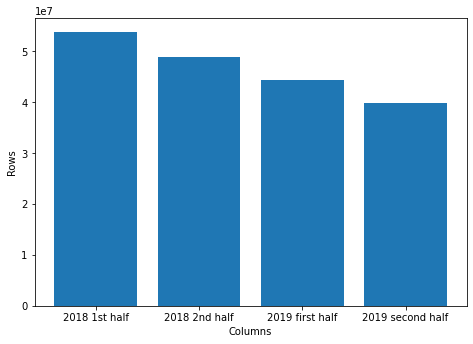

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

dataset = ['2018 1st half', '2018 2nd half', '2019 first half', '2019 second half']
rows = [row2018_1,row2018_2,row2019_1,row2019_2]
plt.xlabel('Columns')
plt.ylabel('Rows')
ax.bar(dataset,rows)
plt.show()

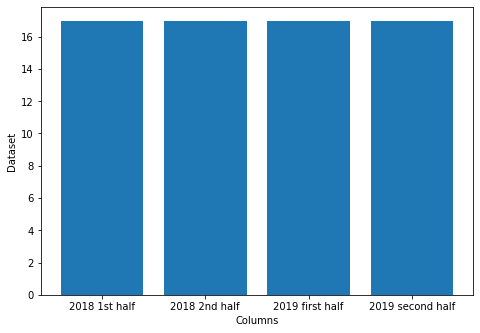

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dataset = ['2018 1st half', '2018 2nd half', '2019 first half', '2019 second half']
columns = [col2018_1,col2018_1,col2018_1,col2018_1]
plt.xlabel('Columns')
plt.ylabel('Dataset')
ax.bar(dataset,columns)
plt.show()

<h4><b> All DATA SET ON GOOGLE CLOUD </B></h4>
<p align="justify">
After using Pyspark and pandas togbq function I uploaded my entire dataset on Google Cloud Platform.The screenshot below depicts the entire Dataset information that I used in my Project:
<ol><li> <b>Schema For Taxi Data set in Google Cloud:</b></li><br>
<center>
<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/Schema.PNG?raw=true"/ height=600>
</center>
<li><b>Table Information for Yellow Taxi Data</b> </li><br>
<center>
<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/2018firsthalf.PNG?raw=true" height=200px width=400px/>

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/2018Secondhalf.PNG?raw=true" height=200px width=400px />

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/2019first.PNG?raw=true" height=200px width=400px />

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/2019second.PNG?raw=true" height=200px width=400px />
</center>

<li><b>Table & Schema Information for Zones in NYC city</b> </li><br>
<center>
<i><u>Table Inforamtion</u></i><br>
<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/zone.PNG?raw=true" height=200px width=400px /><br>
<i><u>Schema Inforamtion</u></i>
<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/schema%20zone.PNG?raw=true" />
</center>

<li><b>Table Information for Weather Data </b> </li><br>
<center>
<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/weather2018.PNG?raw=true" height=200px width=400px />
<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/weather2019.PNG?raw=true" height=200px width=400px />

</center>

</ol>
</p>


<p align="justify">Understanding Discovery:
Discovery is an information-gathering process meant to dig deep into the details of what is important to a client's business, target audience, and industry. The more information you gather, interpret, and comprehend, the more prepared you will be to execute a site on budget and on target. This step was essential to determine the following :

<ul>
<li>Drafting a business problem statement.</li>
<li>Reframing the problem as an analytics </li>
challenge.
<li>Assess resource needs and availability. </li>
<li>Draft an analytic plan. </li>
</ul>

Scope and depth of research and inquiry will differ from project to project, but the results are the same: valuable data. 


</p>